## The Start
- DQN으로 카트폴 푸는 것은 꽤나 어렵다...!

In [18]:
import gym
import copy
import random
import numpy as np
import pandas as pd
from tqdm import tqdm
from collections import deque
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

SEED = 511
np.random.seed(SEED)
torch.manual_seed(SEED)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [19]:
################################## set device ##################################
print("============================================================================================")
# set device to cpu or cuda
device = torch.device('cpu')
if(torch.cuda.is_available()):
    device = torch.device('cuda:0')
    torch.cuda.empty_cache()
    print("Device set to : " + str(torch.cuda.get_device_name(device)))
else:
    print("Device set to : cpu")
print("============================================================================================")

Device set to : NVIDIA A100-SXM4-40GB


## QNetwork

In [20]:
class QNetwork(nn.Module):
    def __init__(self, state_dim, num_action):
        super(QNetwork, self).__init__()
        self.fc1 = nn.Linear(state_dim, 128)
        self.fc2 = nn.Linear(128, 128)
        self.fc3 = nn.Linear(128, num_action)
        # DQN은 선택 가능한 action들 중 하나를 선택하므로
        # num_action이라고 표기하는 게 합리적임.

    def forward(self, x):
        x = F.elu(self.fc1(x))
        x = F.elu(self.fc2(x))
        x = self.fc3(x)
        return x

## Replay Buffer
- experience 저장 및 샘플링해서 학습에 사용

In [21]:
# state는 처음 들어올 때    [-1.3424444  -0.03701451 -0.0992636   1.4787225 ] 형태로 들어옴
# action은 처음 들어올 때   scalar 1 형태로 들어옴


class ReplayBuffer:
    def __init__(self, state_dim, buff_size):
        self.state_buff = np.zeros([buff_size, state_dim], dtype=np.float32)
        self.action_buff = np.zeros([buff_size, 1], dtype=np.long)
        self.reward_buff = np.zeros([buff_size, 1], dtype=np.float32)
        self.next_state_buff = np.zeros([buff_size, state_dim], dtype=np.float32)
        self.done_buff = np.zeros([buff_size, 1], dtype=np.float32)

        self.ptr = 0
        self.size = 0
        self.max_size = buff_size

    def store(self, state, action, reward, next_state, done):
        self.state_buff[self.ptr] = state
        self.action_buff[self.ptr] = action
        self.reward_buff[self.ptr] = reward
        self.next_state_buff[self.ptr] = next_state
        self.done_buff[self.ptr] = done

        self.ptr = (self.ptr + 1) % self.max_size
        self.size = min(self.size + 1, self.max_size)

    def sample(self):
        idx= np.random.randint(0, self.size, size=256) # 랜덤하게 experience를 뽑아옴

        return dict(state=torch.tensor(self.state_buff[idx], dtype=torch.float32).to(device),
                    action=torch.tensor(self.action_buff[idx], dtype=torch.long).to(device),
                    reward=torch.tensor(self.reward_buff[idx], dtype=torch.float32).to(device),
                    next_state=torch.tensor(self.next_state_buff[idx], dtype=torch.float32).to(device),
                    done=torch.tensor(self.done_buff[idx]).to(device)
                    )

## Agent

In [22]:
class Agent:
    def __init__(self, state_dim, num_action):
        self.eps = 0.99
        self.eps_min = 0.03
        self.eps_decay = 0.94
        self.gamma = 0.98
        self.target_update_freq = 3

        self.qnet = QNetwork(state_dim, num_action).to(device)
        self.target_qnet = copy.deepcopy(self.qnet)
        self.optimizer = optim.Adam(self.qnet.parameters(), lr=0.00056)
        self.criterion = nn.MSELoss()

    def get_action(self, state, timestep):
        if (timestep == 1):
            self.eps = 0.99 # 초기에는 매우 높은 확률로 Random_Action 시킴.

        elif (self.eps >= self.eps_min): # min보다 클 때는 eps 계속 낮춰줌.
            self.eps *= self.eps_decay

        elif (self.eps < self.eps_min): # 시간 지나면 eps_min값으로 고정.
            self.eps = self.eps_min

        if random.random() > self.eps:
            action = self.qnet(state).detach().squeeze().cpu().numpy().argmax(axis=0)
            return int(action)
        else:
            action = env.action_space.sample()
            return int(action)


    def learn(self, batch, current_epi):
        state = batch['state'] # tensor([[-1.0468, -0.8232,  1.4239,  0.4460],
        #                                [-8.8516e-01,  4.3342e-02,  1.6168e+00, -7.7498e-01], .......<class 'torch.Tensor'>

        action = batch['action'] # tensor([[1],
        #                                  [0],
        #                                  [0],

        reward = batch['reward'] # tensor([[1.],
        #                                  [1.],
        #                                  [1.],

        next_state = batch['next_state'] # state와 같음

        done = batch['done'] #tensor([[0.],
        #                             [0.],
        #                             [0.],


        # Q(S,A)에 해당하는 부분임.
        # Q값은 ANN으로 예측한 건데, 그 중에서 실제로 했던 action을 gather 활용해 찾음.
        # dim=1이니까 0열과 1열 중에서 index에 맞는 것들을 골라올 거임
        current_q = self.qnet(state).gather(dim=1, index=action) # tensor([[0.3761],
        #                                                                  [0.3822],
        #                                                                  [0.3724],....... grad_fn=<GatherBackward0>)

        # max Q(S',A')에 해당하는 부분임.
        # 각 행마다 0과 1에 대하여 Q값이 나왔는데, dim=1이니까 max에 해당하는 열만 뽑아옴
        next_q = self.target_qnet(next_state).max(dim=1)[0].reshape(-1, 1)#tensor([[0.3761],
        #                                                                          [0.3822],
        #                                                                          [0.3724],....... grad_fn=<ReshapeAliasBackward0>)

        # R + gamma * max Q(S',A')
        td_target = reward + self.gamma * next_q * (1-done)

        # td_error = td_target - current_q
        loss = self.criterion(current_q, td_target)

        self.optimizer.zero_grad()
        loss.backward()

        # Q(S,A) <---- Q(S,A) + alpha*[R + gamma*max Q(S',A') - Q(S,A)]
        self.optimizer.step()

        # 때마다 Target_Network를 업데이트 해줌.
        if current_epi % self.target_update_freq == 0:
            self.target_qnet.load_state_dict(self.qnet.state_dict())


## Config.

In [23]:
# new_step_api ---> gym에서 step 메소드에 대한 업데이트 사항.
env = gym.make('CartPole-v1', new_step_api=True, render_mode='human')
env.reset(SEED)

state_dim = env.observation_space.shape[0]
num_action = env.action_space.n

# 카트폴에서는 Episode 300쯤 가야 50_000개 채움.
# 초기에 쌓았던 질 나쁜 데이터 물갈이 하려면
# Buffer_Size를 너무 키우면 안 됨.
# i.e. Buffer_Size를 겜 봐가면서 설정해야 한다.
memory = ReplayBuffer(state_dim, buff_size=25_000)
agent = Agent(state_dim, num_action)

/usr/local/lib/python3.10/dist-packages/gym/core.py:256: DeprecationWarning: WARN: Function `env.seed(seed)` is marked as deprecated and will be removed in the future. Please use `env.reset(seed=seed)` instead.
  deprecation(
<ipython-input-21-d9065dee603d>:8: DeprecationWarning: `np.long` is a deprecated alias for `np.compat.long`. To silence this warning, use `np.compat.long` by itself. In the likely event your code does not need to work on Python 2 you can use the builtin `int` for which `np.compat.long` is itself an alias. Doing this will not modify any behaviour and is safe. When replacing `np.long`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  self.action_buff = np.zeros([buff_size, 1], dtype=np.long)


## Training

In [24]:
total_reward = []

for epi in tqdm(range(1, 300+1)):

    state = env.reset()
    # [-0.00824687  0.03277586 -0.00118139  0.0188767 ], (4,)

    done = False

    timestep = int(0)
    reward_per_epi = 0.0
    while not done:
        timestep += int(1)

        action = agent.get_action(torch.tensor(state, dtype=torch.float32).to(device), timestep=timestep)

        info = env.step(action)
        next_state = info[0]
        reward = info[1]
        done = info[2]

        memory.store(state, action, reward, next_state, done)

        state = next_state

        if memory.size >= 500:
            batch = memory.sample()
            agent.learn(batch, current_epi=epi)

        reward_per_epi += reward

        # 가끔씩 안 끝나서 만들어줬음.
        if reward_per_epi >= 450.0:
            done = True

    if epi % 10 == 0:
        print(f'[Epi]:{epi}  |  [Buff_Size]: {memory.size}  |  [Cum_Reward]: {reward_per_epi}')

    total_reward.append( reward_per_epi )

  3%|▎         | 10/300 [00:04<02:11,  2.20it/s]

[Epi]:10  |  [Buff_Size]: 196  |  [Cum_Reward]: 34.0


  7%|▋         | 20/300 [00:08<02:09,  2.16it/s]

[Epi]:20  |  [Buff_Size]: 378  |  [Cum_Reward]: 34.0


 10%|█         | 30/300 [00:12<01:52,  2.40it/s]

[Epi]:30  |  [Buff_Size]: 568  |  [Cum_Reward]: 15.0


 13%|█▎        | 40/300 [00:17<02:39,  1.63it/s]

[Epi]:40  |  [Buff_Size]: 820  |  [Cum_Reward]: 15.0


 17%|█▋        | 50/300 [00:37<09:20,  2.24s/it]

[Epi]:50  |  [Buff_Size]: 1789  |  [Cum_Reward]: 12.0


 20%|██        | 60/300 [01:37<22:02,  5.51s/it]

[Epi]:60  |  [Buff_Size]: 4813  |  [Cum_Reward]: 256.0


 23%|██▎       | 70/300 [02:04<05:39,  1.48s/it]

[Epi]:70  |  [Buff_Size]: 6131  |  [Cum_Reward]: 9.0


 27%|██▋       | 80/300 [02:53<18:06,  4.94s/it]

[Epi]:80  |  [Buff_Size]: 8534  |  [Cum_Reward]: 266.0


 30%|███       | 90/300 [03:37<15:51,  4.53s/it]

[Epi]:90  |  [Buff_Size]: 10724  |  [Cum_Reward]: 252.0


 33%|███▎      | 100/300 [04:18<11:45,  3.53s/it]

[Epi]:100  |  [Buff_Size]: 12752  |  [Cum_Reward]: 14.0


 37%|███▋      | 110/300 [05:03<10:18,  3.26s/it]

[Epi]:110  |  [Buff_Size]: 14975  |  [Cum_Reward]: 15.0


 40%|████      | 120/300 [05:40<10:36,  3.54s/it]

[Epi]:120  |  [Buff_Size]: 16804  |  [Cum_Reward]: 154.0


 43%|████▎     | 130/300 [06:10<09:11,  3.24s/it]

[Epi]:130  |  [Buff_Size]: 18298  |  [Cum_Reward]: 172.0


 47%|████▋     | 140/300 [06:24<02:56,  1.10s/it]

[Epi]:140  |  [Buff_Size]: 19013  |  [Cum_Reward]: 21.0


 50%|█████     | 150/300 [06:52<08:29,  3.40s/it]

[Epi]:150  |  [Buff_Size]: 20390  |  [Cum_Reward]: 170.0


 53%|█████▎    | 160/300 [07:11<02:19,  1.00it/s]

[Epi]:160  |  [Buff_Size]: 21290  |  [Cum_Reward]: 10.0


 57%|█████▋    | 170/300 [07:30<04:46,  2.21s/it]

[Epi]:170  |  [Buff_Size]: 22245  |  [Cum_Reward]: 138.0


 60%|██████    | 180/300 [08:10<09:56,  4.97s/it]

[Epi]:180  |  [Buff_Size]: 24240  |  [Cum_Reward]: 262.0


 63%|██████▎   | 190/300 [08:45<07:47,  4.25s/it]

[Epi]:190  |  [Buff_Size]: 25000  |  [Cum_Reward]: 213.0


 67%|██████▋   | 200/300 [09:23<05:01,  3.02s/it]

[Epi]:200  |  [Buff_Size]: 25000  |  [Cum_Reward]: 173.0


 70%|███████   | 210/300 [09:50<03:36,  2.40s/it]

[Epi]:210  |  [Buff_Size]: 25000  |  [Cum_Reward]: 18.0


 73%|███████▎  | 220/300 [10:40<08:46,  6.58s/it]

[Epi]:220  |  [Buff_Size]: 25000  |  [Cum_Reward]: 450.0


 77%|███████▋  | 230/300 [11:52<08:49,  7.56s/it]

[Epi]:230  |  [Buff_Size]: 25000  |  [Cum_Reward]: 450.0


 80%|████████  | 240/300 [13:01<06:24,  6.41s/it]

[Epi]:240  |  [Buff_Size]: 25000  |  [Cum_Reward]: 209.0


 83%|████████▎ | 250/300 [13:25<02:33,  3.07s/it]

[Epi]:250  |  [Buff_Size]: 25000  |  [Cum_Reward]: 13.0


 87%|████████▋ | 260/300 [14:12<01:57,  2.95s/it]

[Epi]:260  |  [Buff_Size]: 25000  |  [Cum_Reward]: 17.0


 90%|█████████ | 270/300 [15:06<02:36,  5.22s/it]

[Epi]:270  |  [Buff_Size]: 25000  |  [Cum_Reward]: 359.0


 93%|█████████▎| 280/300 [16:10<02:30,  7.55s/it]

[Epi]:280  |  [Buff_Size]: 25000  |  [Cum_Reward]: 450.0


 97%|█████████▋| 290/300 [17:27<01:18,  7.86s/it]

[Epi]:290  |  [Buff_Size]: 25000  |  [Cum_Reward]: 450.0


100%|██████████| 300/300 [18:10<00:00,  3.63s/it]

[Epi]:300  |  [Buff_Size]: 25000  |  [Cum_Reward]: 450.0


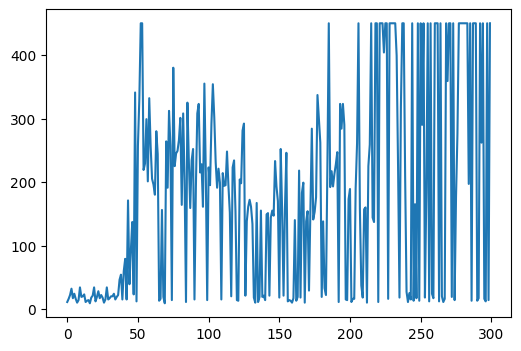

In [27]:
fig, ax = plt.subplots(1,1, figsize=(6, 4))

ax.plot(range(len(total_reward)), total_reward)

plt.show()

## The End